In [9]:
from pandas_datareader import data as pdr
import datetime as dt
import pandas as pd
import yfinance as yf
import requests
from  SELIC_tax import calculate_average_selic_annual
from asset_download import stocks_dataframe
from plot_EF import plot_efficient_frontier

from pypfopt import EfficientFrontier, EfficientSemivariance, expected_returns, risk_models, plotting
from pypfopt.cla import CLA
from sklearn.linear_model import LinearRegression

from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import scipy.cluster.hierarchy as shc
from scipy import stats
import plotly.express as px
import pickle

### Teste Data

In [2]:
start = dt.date(2015,1,1)
end = dt.date.today()
#end = 10
type(end) == dt.date

True

### Ações para teste

In [3]:
stocks_cod = ['ABEV3','PETR3' ,'MGLU3','ITUB3','ALPA3', 'VIVT3', 'WEGE3', 'VALE3', 'BBAS3']
stocks_cod = [stock +'.SA' for stock in stocks_cod]
stocks_cod

['ABEV3.SA',
 'PETR3.SA',
 'MGLU3.SA',
 'ITUB3.SA',
 'ALPA3.SA',
 'VIVT3.SA',
 'WEGE3.SA',
 'VALE3.SA',
 'BBAS3.SA']

### Teste selic apis

In [ ]:
#Teste api selic especifica python
from bcb import sgs

selic = sgs.get(('selic', 432), start = '2020-02-01', end = '2023-06-14')

selic = selic.rename_axis('data').reset_index()

selic['data'] = list(map(lambda x: x.year, selic['data']))


selic.groupby('data')['selic'].mean(), np.mean(selic.groupby('data')['selic'].mean())

In [ ]:
#Teste selic api por url
serie = 432
url = f'https://api.bcb.gov.br/dados/serie/bcdata.sgs.{serie}/dados?formato=json'
data_t = pd.read_json(url)

# convert to datetime
data_t['data'] = pd.to_datetime(data_t['data'], dayfirst = True)

# year column, grouping by year and aggregate average
data_t['ano'] = data_t['data'].dt.year
selic_annual = data_t.groupby('ano')['valor'].mean().reset_index()
selic_annual[(selic_annual['ano']>= 2020) & (selic_annual['ano']<=2023)]

In [ ]:
selic_annual[(selic_annual['ano']>= 2020) & (selic_annual['ano']<=2023)]['valor'].mean()

In [ ]:
"""
def calculate_average_selic_annual(year1, year2 = 0):
    
    import datetime as dt
    import pandas as pd
    
    if year2 == 0:
        year2 = dt.date.today().year
        
    if year1 > year2:
        
        raise ValueError("Primeiro ano deve ser menor que o segundo ano.")
        
    # api extract selic
    serie = 432
    url = f'https://api.bcb.gov.br/dados/serie/bcdata.sgs.{serie}/dados?formato=json'
    data = pd.read_json(url)
    
    # convert to datetime
    data['data'] = pd.to_datetime(data['data'], dayfirst = True)
    
    # year column, grouping by year and aggregate average
    data['ano'] = data['data'].dt.year
    selic_annual = data.groupby('ano')['valor'].mean()
    
    # average selic rate of the years
    rate_w_risk = selic_annual[(selic_annual.index > year1) & (selic_annual.index < year2)].mean()
    
    return round(rate_w_risk/100,4)

As duas apresentaram pouca diferença, apenas nas casas decimais na taxa anual em 2020.

### Coleta dos dados dos ativos pelo API yfinance

In [ ]:
 def stocks_dataframe(start, end = 0, *stocks_id:list):   
    
    if end == 0:
        end = dt.date.today()
        
    
    # convert string date in datetime
    start = dt.datetime.strptime(start, '%d/%m/%Y')
    
    if type(end) != dt.date:
        end  = dt.datetime.strptime(end, '%d/%m/%Y')
    
    stock_data = pd.DataFrame()
    
   
        
        # iterate stocks args  
    for i in stocks_id:


        for asset in i:

            try:
                # get close data stocks in yahoo finance API
                close = yf.download(asset, start=start, end=end)['Adj Close']

                # add adj close value
                stock_data[asset] = close
            except Exception as e:
                print(f"Error downloading data for {asset}: {str(e)}")


    stock_data.fillna(0, inplace = True)
    return stock_data

In [ ]:
dt.datetime.strptime(date, "%d/%m/%Y").year

In [80]:
day = 365 * 3
date = dt.datetime.strftime(dt.date.today() - dt.timedelta(days = day),"%d/%m/%Y")
data = stocks_dataframe(date,0,stocks_cod)
columns = data.columns
index = data.index

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [81]:
data.head()

,ABEV3.SA,PETR3.SA,MGLU3.SA,ITUB3.SA,ALPA3.SA,VIVT3.SA,WEGE3.SA,VALE3.SA,BBAS3.SA
Date,,,,,,,,,
2020-06-17,12.206976,9.376196,16.670734,21.911930,24.036743,40.164719,22.177752,40.941219,27.716032
2020-06-18,12.127192,9.523685,17.293495,22.474926,24.066393,40.943195,22.163336,40.919361,27.635698
2020-06-19,12.269030,9.388836,17.715288,23.583036,24.511152,41.316223,22.201771,40.190876,27.266140
2020-06-22,12.508382,9.216063,17.591234,22.617905,24.689056,40.375557,21.908699,40.067036,26.703798
2020-06-23,12.348815,9.485759,17.429960,22.421305,24.629755,39.929558,22.158539,40.496845,26.936773


### Tratamento e calculos pre-processamento

In [82]:
def replaceZeroes(data):
    min_nonzero = np.min(data[np.nonzero(data)])
    data[data == 0] = min_nonzero
    return data

data = pd.DataFrame(columns = columns, data = data, index = index)
returns = data.pct_change().apply(lambda x: np.log1p(x)).fillna(0, axis = 1)

# annual returns
mean = returns.mean() *252

# deviation
sigma =  returns.std(axis = 0) * np.sqrt(252)

cov_matrix = returns.cov() * 252
cov_matrix

,ABEV3.SA,PETR3.SA,MGLU3.SA,ITUB3.SA,ALPA3.SA,VIVT3.SA,WEGE3.SA,VALE3.SA,BBAS3.SA
ABEV3.SA,0.080332,0.037035,0.038815,0.036559,0.022524,0.021196,0.029851,0.009322,0.037877
PETR3.SA,0.037035,0.169621,0.039609,0.052781,0.019193,0.014370,0.024359,0.046126,0.077824
MGLU3.SA,0.038815,0.039609,0.457257,0.042374,0.098770,0.027823,0.070545,0.018900,0.052301
ITUB3.SA,0.036559,0.052781,0.042374,0.085678,0.024251,0.019711,0.027112,0.022790,0.059080
ALPA3.SA,0.022524,0.019193,0.098770,0.024251,0.205938,0.017445,0.038242,0.005489,0.023579
VIVT3.SA,0.021196,0.014370,0.027823,0.019711,0.017445,0.051145,0.017729,0.001659,0.022552
WEGE3.SA,0.029851,0.024359,0.070545,0.027112,0.038242,0.017729,0.123343,0.019518,0.025681
VALE3.SA,0.009322,0.046126,0.018900,0.022790,0.005489,0.001659,0.019518,0.120772,0.022702
BBAS3.SA,0.037877,0.077824,0.052301,0.059080,0.023579,0.022552,0.025681,0.022702,0.102464


In [83]:
returns.head()

,ABEV3.SA,PETR3.SA,MGLU3.SA,ITUB3.SA,ALPA3.SA,VIVT3.SA,WEGE3.SA,VALE3.SA,BBAS3.SA
Date,,,,,,,,,
2020-06-17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-06-18,-0.006557,0.015608,0.036676,0.025369,0.001233,0.019197,-0.000650,-0.000534,-0.002903
2020-06-19,0.011628,-0.014261,0.024098,0.048127,0.018312,0.009070,0.001733,-0.017963,-0.013463
2020-06-22,0.019321,-0.018573,-0.007027,-0.041786,0.007232,-0.023031,-0.013288,-0.003086,-0.020840
2020-06-23,-0.012839,0.028844,-0.009210,-0.008730,-0.002405,-0.011108,0.011339,0.010670,0.008687


In [26]:
def return_portfolio(w, ret):
    # return capm
    return  (w* ret).sum()

    #return  expected_returns.capm_return(data)

def cov_portfolio(w, cov_matrix):
    # risk calculation    
    return np.sqrt(np.dot(w.T, (np.dot(cov_matrix, w))))
    #return risk_models.CovarianceShrinkage(data).ledoit_wolf()


In [10]:
tax_w_risk = calculate_average_selic_annual(2020)
tax_w_risk

0.0843

### Fronteira eficiente passa a passo

In [ ]:
columns = [x for x in data.columns]
lista = ['Retorno P %', 'Risco %', 'Indice Sharpe']
columns.extend(lista)

simulacao = pd.DataFrame(columns=[columns])
simulacao

In [ ]:
N = 100

for x in range (N):
    
    np.random.seed(x)
    
    # pesos aleatorios e normalizando
    w = np.random.random(9)
    w = np.array(w/w.sum())
    
    sigma = cov_portfolio(w, cov_matrix)*100
    
    ret = return_portfolio(w, mean).sum() *100
    sharp_r = (ret - tax_w_risk) / sigma

    simulacao.loc[x] = [round(w[0], 3), round(w[1],3), round(w[2],3),round(w[3],3),round(w[4],3),
                        round(w[5],3), round(w[6],3), round(w[7],3), round(w[8],3),
                        round(ret,2), round(sigma,2), round(sharp_r, 4)]

    
# Gráfico
plt.figure(figsize= (15,10))
plt.scatter(simulacao['Risco %'], simulacao['Retorno P %'], c = simulacao['Indice Sharpe'])
plt.colorbar(label = 'Sharpe ratio')
#plt.legend(bbox_to_anchor=(1.3, 0.6)) 
plt.tight_layout()   


In [ ]:
maxi = simulacao['Indice Sharpe'].max()[0]
maxi

## Montagem de portfólios com otimizaçães

### Biblioteca pypfopt

#### Otimização max sharpe ratio

In [11]:
expected_r = expected_returns.capm_return(data)
estimative = risk_models.CovarianceShrinkage(data).ledoit_wolf()
ef1 = EfficientFrontier(expected_r, estimative)
ef1.max_sharpe()
ret_tangent, std_tangent, _ = ef1.portfolio_performance(verbose = True)

Expected annual return: 9.8%
Annual volatility: 21.3%
Sharpe Ratio: 0.37


#### Otimização CLA minima volatilidade

In [12]:
ef2 = CLA(expected_r, estimative)
ef2.min_volatility()
ef2.portfolio_performance(verbose = True,risk_free_rate=tax_w_risk)

Expected annual return: 7.3%
Annual volatility: 17.3%
Sharpe Ratio: -0.07


(0.07260016400899698, 0.17291475603872722, -0.06766244974710338)

#### Otimização máxima utilidade 

In [13]:
ef3 = EfficientFrontier(expected_r, estimative)
ef3.max_quadratic_utility()
ef3.portfolio_performance(verbose = True, risk_free_rate=tax_w_risk)

Expected annual return: 11.4%
Annual volatility: 26.5%
Sharpe Ratio: 0.11


(0.11418498767128812, 0.26482756755339737, 0.11284696660313656)

#### Separação dos Pesos e multiplicação pelo valor investido

In [14]:
w_sharpe = dict(ef1.clean_weights())
w_risk = dict(ef2.clean_weights())
w_return = dict(ef3.clean_weights())

values_sharpe = np.dot(list(w_sharpe.values()),1000)
values_risk = np.dot(list(w_risk.values()),1000)
values_return = np.dot(list(w_return.values()),1000)
#################################################

### Otimização HRP

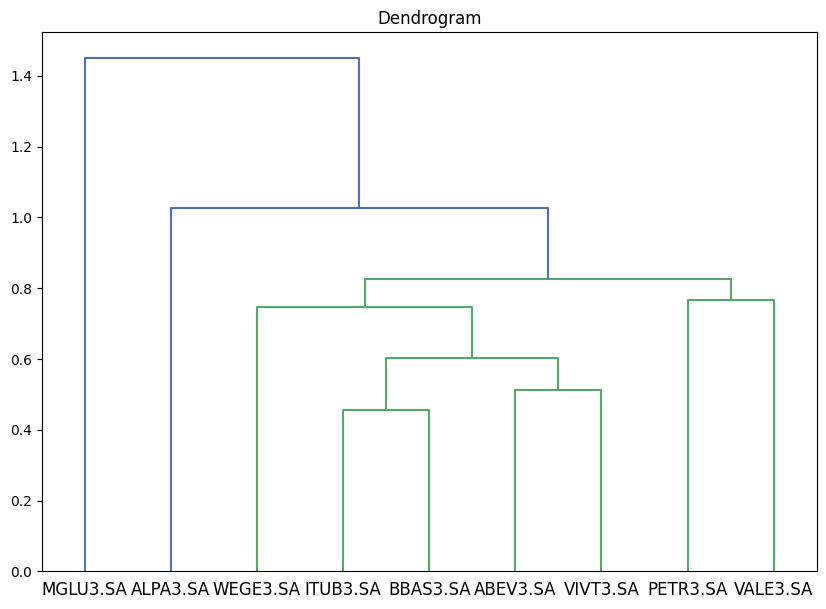

In [15]:

plt.figure(figsize=(10, 7))  
plt.title("Dendrogram")

clusters = shc.linkage(returns.T, method='ward', metric='euclidean')

dendogram = shc.dendrogram(clusters, labels=returns.columns)

In [16]:
def matrix_seriation(returns: pd.DataFrame):

    matrix_cov = returns.cov()

    dendogram = sns.clustermap(matrix_cov, method='ward', metric='euclidean')
    
    seriation = dendogram.dendrogram_col.reordered_ind
    columns_seriation = returns.columns[seriation]

    return (matrix_cov, columns_seriation)

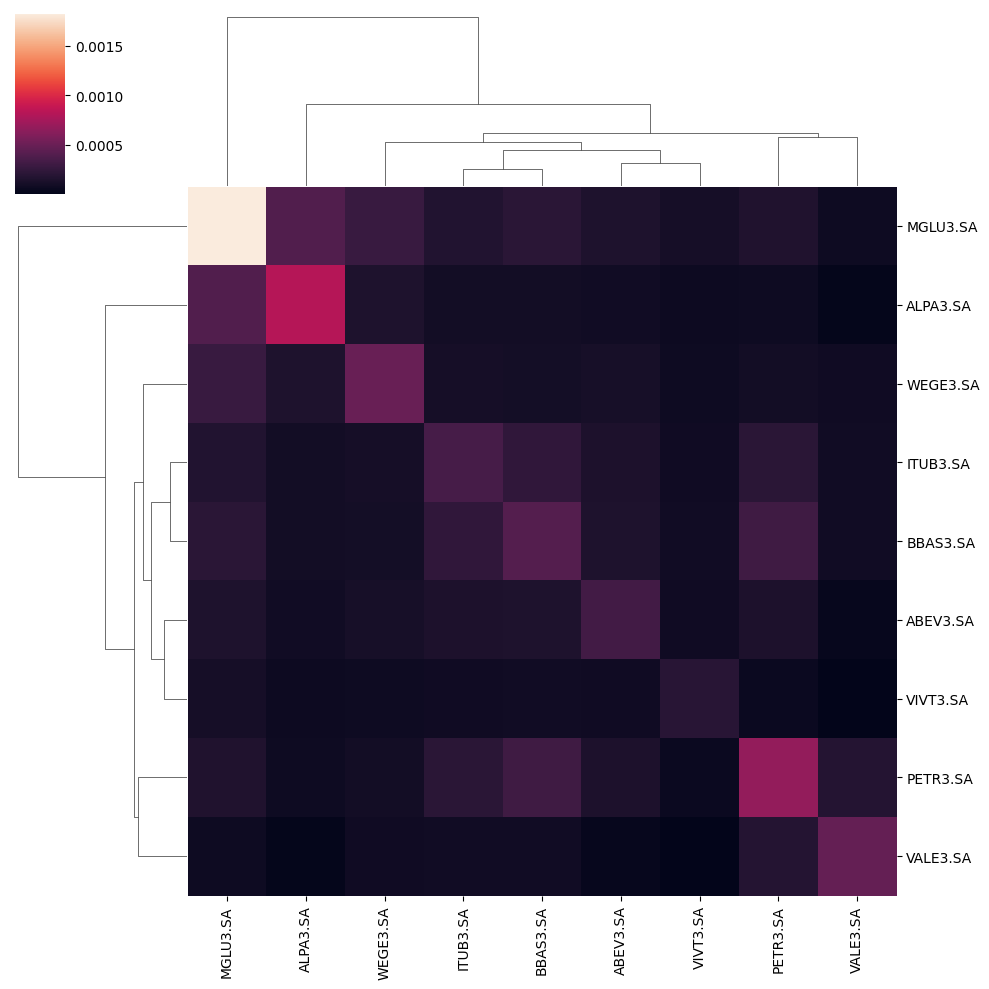

In [17]:
matrix_cov, columns_seriation = matrix_seriation(returns)

In [ ]:
def calcula_pesos_hrp(matriz_cov, colunas_seriation):
    # Inicialização de pesos
    pesos = pd.Series(1, index=colunas_seriation)
    paridades = [colunas_seriation]

    while len(paridades) > 0:
        # Instanciação de clusters
        paridades = [cluster[inicio:fim] 
                     for cluster in paridades
                      for inicio, fim in ((0, len(cluster) // 2),(len(cluster) // 2, len(cluster)))
                        if len(cluster) > 1]

        # Iteração entre paridades
        for subcluster in range(0, len(paridades), 2):
            
            cluster_esquerdo = paridades[subcluster]
            cluster_direito = paridades[subcluster + 1]
            
            matriz_cov_esquerda = matriz_cov[cluster_esquerdo].loc[cluster_esquerdo]
            inversa_diagonal = 1 / np.diag(matriz_cov_esquerda.values)
            pesos_cluster_esquerdo = inversa_diagonal / np.sum(inversa_diagonal)
            vol_cluster_esquerdo = np.dot(pesos_cluster_esquerdo, np.dot(matriz_cov_esquerda, pesos_cluster_esquerdo))

            matriz_cov_direita = matriz_cov[cluster_direito].loc[cluster_direito]
            inversa_diagonal = 1 / np.diag(matriz_cov_direita.values)
            pesos_cluster_direito = inversa_diagonal  / np.sum(inversa_diagonal)
            vol_cluster_direito = np.dot(pesos_cluster_direito, np.dot(matriz_cov_direita, pesos_cluster_direito))

            fator_alocacao = 1 - vol_cluster_esquerdo / (vol_cluster_esquerdo + vol_cluster_direito)

            pesos[cluster_esquerdo] *= fator_alocacao
            pesos[cluster_direito] *= 1 - fator_alocacao
            
    return pesos

MGLU3.SA    0.029307
ALPA3.SA    0.065072
WEGE3.SA    0.111963
ITUB3.SA    0.161184
BBAS3.SA    0.102123
ABEV3.SA    0.130259
VIVT3.SA    0.258087
PETR3.SA    0.059059
VALE3.SA    0.082946
dtype: float64

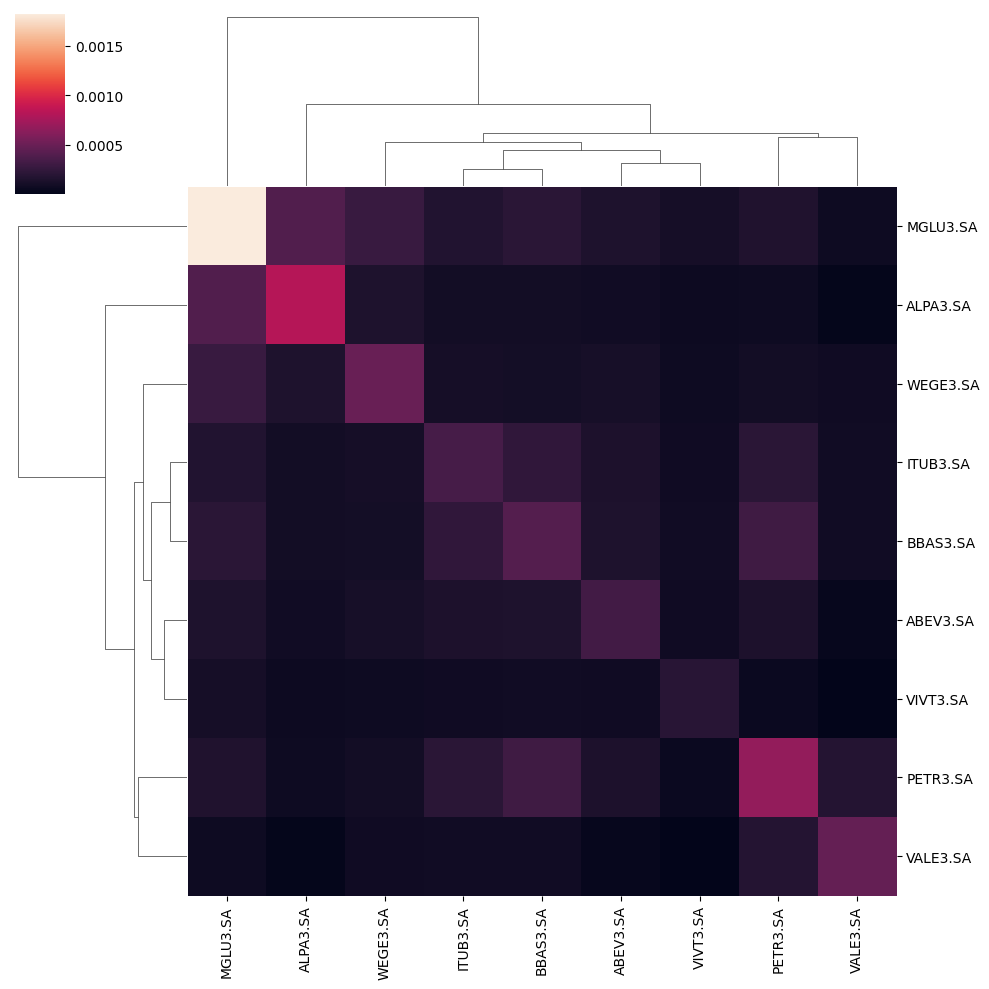

In [19]:
# teste função criada
from HRP_PortfOpt import HRP
hrp = HRP(returns)
hrp.calculate_hrp()

In [20]:
columns_seriation = hrp._columns_s

#### Pesos otimização HRP

In [23]:
w_hrp =hrp.calculate_hrp()
w_hrp = list(w_hrp)
w_hrp

[0.02930696691216656,
 0.06507185502572373,
 0.11196301490748792,
 0.1611840036995841,
 0.10212316473602437,
 0.13025854539690415,
 0.2580874159077639,
 0.05905875958098381,
 0.08294627383336146]

Reordenação dos pesos conforme dataframe.

In [41]:

w_sharpe
data.columns
columns_seriation
dict_columns = {}

for columns, value in zip(data.columns, w_hrp):
    
    dict_columns[columns] = w_hrp[list(columns_seriation).index(columns)]
    
dict_columns

{'ABEV3.SA': 0.13025854539690415,
 'PETR3.SA': 0.05905875958098381,
 'MGLU3.SA': 0.02930696691216656,
 'ITUB3.SA': 0.1611840036995841,
 'ALPA3.SA': 0.06507185502572373,
 'VIVT3.SA': 0.2580874159077639,
 'WEGE3.SA': 0.11196301490748792,
 'VALE3.SA': 0.08294627383336146,
 'BBAS3.SA': 0.10212316473602437}

##### Pesos HRP x valor investido, calculo retorno e sharpe

In [55]:
values_hrp = np.dot(weights_,1000)

In [56]:
weights_ = np.array(list(dict_columns.values()))
sigma_ = cov_portfolio(weights_, cov_matrix)*100
 
ret_ = return_portfolio(weights_, mean).sum() *100
sharp_r_ = (ret_ - tax_w_risk) / sigma_
sharp_r_

0.36888537460791126

#### Adicionando ao dataframe rendimento dos portfolios diários

In [57]:
returns['sharpe otm'] = 0
returns['cla otm'] = 0
returns['max_sqrt otm'] = 0
returns['hrp otm'] = 0


for i in range(len(data)-1):
    sum_all_sharpe = 0
    sum_all_risk = 0
    sum_all_return = 0
    sum_all_hrp = 0
    
    for x in range(len(values_sharpe)):
        
        # sum returns sharpe weights
        sharpe = (1+(returns.iloc[i,x]))* values_sharpe[x]
        sum_all_sharpe = sum_all_sharpe + sharpe
        values_sharpe[x] = sharpe
        
        # sum returns risk weights
        risk = (1+(returns.iloc[i,x]))* values_risk[x]
        sum_all_risk = sum_all_risk + risk
        values_risk[x] = risk
        
        # sum returns return weights
        return_ = (1+(returns.iloc[i,x]))* values_return[x]
        sum_all_return = sum_all_return + return_
        values_return[x] = return_
        
         # sum returns hrp weights
        hrp = (1+(returns.iloc[i,x]))* values_hrp[x]
        sum_all_hrp = sum_all_hrp + hrp
        values_hrp[x] = hrp
        
    returns['sharpe otm'].iloc[i] = sum_all_sharpe
    returns['cla otm'].iloc[i] = sum_all_risk
    returns['max_sqrt otm'].iloc[i] = sum_all_return
    returns['hrp otm'].iloc[i] = sum_all_hrp

C:\Users\prpau\AppData\Local\Temp\ipykernel_18660\2232978491.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\prpau\AppData\Local\Temp\ipykernel_18660\2232978491.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\prpau\AppData\Local\Temp\ipykernel_18660\2232978491.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\prpau\AppData\Local\Temp\ipykernel_18660\2232978491.py:38: SettingWithCopyWarning:


A v

In [58]:
returns.head()

,ABEV3.SA,PETR3.SA,MGLU3.SA,ITUB3.SA,ALPA3.SA,VIVT3.SA,WEGE3.SA,VALE3.SA,BBAS3.SA,sharpe otm,cla otm,max_sqrt otm,hrp otm
Date,,,,,,,,,,,,,
2020-06-18,-0.006557,0.015608,0.036676,0.025369,0.001233,0.019197,-0.000650,-0.000534,-0.002903,1941.165768,1322.618144,2347.309555,1188.827583
2020-06-19,0.011628,-0.014260,0.024098,0.048127,0.018312,0.009069,0.001733,-0.017964,-0.013462,1929.637365,1324.460871,2326.328201,1194.791742
2020-06-22,0.019321,-0.018574,-0.007027,-0.041785,0.007232,-0.023031,-0.013289,-0.003086,-0.020840,1900.037131,1309.067098,2285.157710,1175.859220
2020-06-23,-0.012839,0.028844,-0.009210,-0.008730,-0.002405,-0.011108,0.011339,0.010670,0.008686,1927.404910,1309.401270,2331.222194,1178.561836
2020-06-24,-0.018110,-0.027016,-0.006426,-0.021758,-0.025194,-0.012260,-0.001519,-0.003604,-0.039853,1886.332232,1294.090721,2272.921510,1157.564918


#### Função suavizar para o gráficos de históricos

In [59]:
def smooth(y, box_pts):
    
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode = 'valid')
    return y_smooth
       
#plt.title('Performance histórica')
#plt.xlabel('Dias');

#### Coleta dados Ibov

In [33]:
ibov = '^BVSP'
day = 365 * 3
ibov_start = dt.date.today() - dt.timedelta(days = day)
df_ibov = yf.download(ibov, start=ibov_start, end=dt.date.today())['Adj Close']
df_ibov

[*********************100%***********************]  1 of 1 completed


Date
2020-06-17     95547.0
2020-06-18     96125.0
2020-06-19     96572.0
2020-06-22     95336.0
2020-06-23     95975.0
                ...   
2023-06-12    117336.0
2023-06-13    116743.0
2023-06-14    119069.0
2023-06-15    119221.0
2023-06-16    118758.0
Name: Adj Close, Length: 746, dtype: float64

#### Cálculos retornos portfólios e Ibov

In [60]:
sharpe_rent = returns['sharpe otm'] / returns['sharpe otm'][0] -1
cla_rent = returns['cla otm'] / returns['cla otm'][0] -1
max_sqrt_rent = returns['max_sqrt otm'] / returns['max_sqrt otm'][0] -1
hrp_rent = returns['hrp otm'] / returns['hrp otm'][0] -1
ibov_rent = df_ibov / df_ibov[0] -1

In [61]:
# add dados np array 
fdr = smooth(ibov_rent,10)
fdr = np.append(fdr,ibov_rent[-1])

### Plot Históricos da rentabilidade

In [62]:
figura = px.line(title = 'Histórico desde 2020')
figura.add_scatter(y = smooth(sharpe_rent,10), name = 'Índice Sharpe')
figura.add_scatter(y = smooth(cla_rent,10), name = 'Mínima Volatilidade')
figura.add_scatter(y = smooth(max_sqrt_rent,10), name = 'Máxima utilidade')
figura.add_scatter(y = smooth(hrp_rent,10), name = 'HRP')
figura.add_scatter(y = smooth(ibov_rent,10), name = 'IBOV')
figura.update_layout(xaxis_title = 'Dias', yaxis_title = 'Rentabilidade')

In [64]:
returns

,ABEV3.SA,PETR3.SA,MGLU3.SA,ITUB3.SA,ALPA3.SA,VIVT3.SA,WEGE3.SA,VALE3.SA,BBAS3.SA,sharpe otm,cla otm,max_sqrt otm,hrp otm
Date,,,,,,,,,,,,,
2020-06-18,-0.006557,0.015608,0.036676,0.025369,0.001233,0.019197,-0.000650,-0.000534,-0.002903,1941.165768,1322.618144,2347.309555,1188.827583
2020-06-19,0.011628,-0.014260,0.024098,0.048127,0.018312,0.009069,0.001733,-0.017964,-0.013462,1929.637365,1324.460871,2326.328201,1194.791742
2020-06-22,0.019321,-0.018574,-0.007027,-0.041785,0.007232,-0.023031,-0.013289,-0.003086,-0.020840,1900.037131,1309.067098,2285.157710,1175.859220
2020-06-23,-0.012839,0.028844,-0.009210,-0.008730,-0.002405,-0.011108,0.011339,0.010670,0.008686,1927.404910,1309.401270,2331.222194,1178.561836
2020-06-24,-0.018110,-0.027016,-0.006426,-0.021758,-0.025194,-0.012260,-0.001519,-0.003604,-0.039853,1886.332232,1294.090721,2272.921510,1157.564918
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-12,0.001320,0.012660,-0.002522,-0.004658,0.016792,0.008019,-0.001324,-0.018306,0.035597,3664.355983,1658.926213,5062.649352,1634.942881
2023-06-13,0.007230,0.000420,-0.051825,0.002967,-0.054018,-0.020752,-0.010653,0.010522,-0.010463,3659.784427,1654.393148,5056.605265,1627.677722
2023-06-14,0.003922,0.042134,0.013210,0.018449,0.048746,0.034127,0.013826,0.017392,0.004924,3773.759480,1689.558722,5232.084005,1665.491842


### Plot histórico rendimentos em quantia

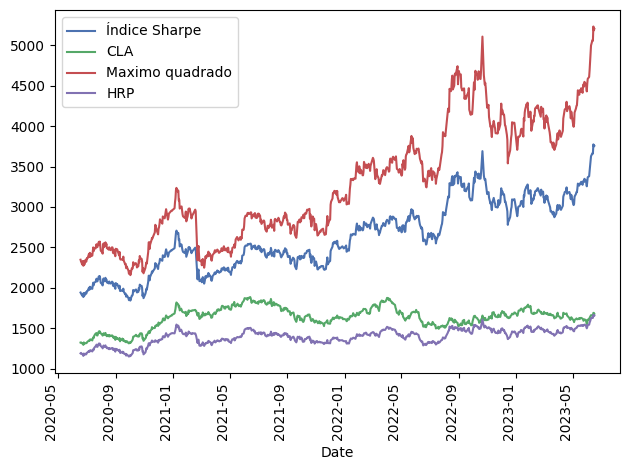

In [63]:
#plt.plot(returns.iloc[:,9:]);
returns.iloc[:,9:].plot(kind = 'line')
plt.legend(['Índice Sharpe', 'CLA', 'Maximo quadrado', 'HRP']);
plt.xticks(rotation = 90)
plt.tight_layout();

In [ ]:
rets = expected_returns.returns_from_prices(data)

### Rentabilidade no período de cada portfólio

In [38]:
df_ = pd.DataFrame((returns.iloc[-1,-4:] /1000 -1) *100)
df_.columns = ['Rentabilidade']
df_['Rentabilidade'] = list(map(lambda x: f'{round(x,2)}%',df_.values.reshape(-1)))
df_

,Rentabilidade
sharpe otm,18.33%
cla otm,10.22%
max_sqrt otm,21.99%
hrp otm,-99.88%


In [ ]:
# teste função HRP
from pypfopt.hierarchical_portfolio import HRPOpt

ef5 = HRPOpt(rets)
ef5.optimize()
ef5.portfolio_performance(verbose = True)

In [ ]:
# teste 
ef5.clean_weights(), w_hrp

### Projeções

#### Função simulação de Monte Carlo

In [ ]:
def monte_carlo_projection(data_returns: pd.DataFrame):
    
    # returns percentage
    returns_pct = np.log1p(data_returns[['sharpe otm','cla otm','max_sqrt otm','hrp otm']].pct_change())
    returns_pct.fillna(0, inplace=True)
    
    # calculcates statistics
    mean_mc = returns_pct.mean()
    var_mc = returns_pct.var()
    drift = mean_mc - (0.5 * var_mc)
    std_mc = returns_pct.std()
    
    
    # simulation params 
    years = 3
    days = 252 * years
    simulation = 1000
    
    # random volatility by multidimensional normal distribution
    np.random.seed(0)
    Z = stats.norm.ppf(np.random.rand(days, simulation))
    daily_sharpe = np.exp(drift[0] + std_returns[0] * Z)
    
    np.random.seed(1)
    Z = stats.norm.ppf(np.random.rand(days, simulation))
    daily_risk = np.exp(drift[1] + std_returns[1] * Z)
    
    np.random.seed(2)
    Z = stats.norm.ppf(np.random.rand(days, simulation))
    daily_mqu = np.exp(drift[2] + std_returns[2] * Z)
    
    np.random.seed(3)
    Z = stats.norm.ppf(np.random.rand(days, simulation))
    daily_hrp = np.exp(drift[3] + std_returns[3] * Z)
    
    # the last row every column to predict
    pred_sharpe = np.zeros_like(daily_sharpe)
    pred_sharpe[0] = returns['sharpe otm'][-1]

    pred_risk = np.zeros_like(daily_risk)
    pred_risk[0] = returns['cla otm'][-1]

    pred_mqu = np.zeros_like(daily_mqu)
    pred_mqu[0] = returns['max_sqrt otm'][-1]

    pred_hrp = np.zeros_like(daily_hrp)
    pred_hrp[0] = returns['hrp otm'][-1]
    
    # calculate projections every day
    for day in range(1, days):
      
        pred_sharpe[day] = pred_sharpe[day - 1] * daily_sharpe[day]
        pred_risk[day] = pred_risk[day - 1] * daily_risk[day]
        pred_mqu[day] = pred_mqu[day - 1] * daily_mqu[day]
        pred_hrp[day] = pred_hrp[day - 1] * daily_hrp[day]
        
    
    # melhores projeçoes
    max_sharpe = np.argmax(pred_sharpe[-1,:].flatten())
    max_risk = np.argmax(pred_risk[-1,:].flatten())
    max_mqu = np.argmax(pred_mqu[-1,:].flatten())
    max_hrp = np.argmax(pred_hrp[-1,:].flatten())

    # piores projeções
    min_sharpe = np.argmin(pred_sharpe[-1,:].flatten())
    min_risk = np.argmin(pred_risk[-1,:].flatten())
    min_mqu = np.argmin(pred_mqu[-1,:].flatten())
    min_hrp = np.argmin(pred_hrp[-1,:].flatten())
    
    #return max_sharpe, max_risk, max_mqu, max_hrp, min_sharpe, min_risk, min_mqu, min_hrp
    return [pred_sharpe, pred_risk, pred_mqu, pred_hrp]

#### Teste simulação

In [ ]:
listas = monte_carlo_projection(returns)
pred_sharpe, pred_risk, pred_mqu, pred_hrp = listas

pred_sharpe[1][0]

### Plot Simulações

In [ ]:
fig = px.line(title = 'Simulações Índice Sharpe')
for i in range(len(pred_sharpe.T)):
    fig.add_scatter(y = pred_sharpe.T[i], name = i);

fig.update_layout(xaxis_title = 'Dias', yaxis_title = 'Rendimento em valor')
fig.show()

In [ ]:
returns_data = np.log1p(returns[['sharpe otm','cla otm','max_sqrt otm','hrp otm']].pct_change())
returns_data.fillna(0, inplace=True)

In [ ]:
returns_data

### Testes passo a passo simulação de Monte Carlo

In [ ]:
mean_returns = returns_data.mean()
var_returns = returns_data.var()
drift = mean_returns - (0.5 * var_returns)

In [ ]:
years = 3
days = 252 * years
simulation = 1000

In [ ]:
std_returns = returns_data.std()

In [ ]:
Z = stats.norm.ppf(np.random.rand(days, simulation))
daily_sharpe = np.exp(drift[0] + std_returns[0] * Z)
daily_risk = np.exp(drift[1] + std_returns[1] * Z)
daily_returns = np.exp(drift[2] + std_returns[2] * Z)
daily_hrp = np.exp(drift[3] + std_returns[3] * Z)

In [ ]:
np.random.normal(0,days)

In [ ]:
Z.shape

In [ ]:
pred_sharpe = np.zeros_like(daily_sharpe)
pred_sharpe[0] = 1000 #returns.iloc[-1,9]

pred_risk = np.zeros_like(daily_risk)
pred_risk[0] = 1000#returns.iloc[-1,10]

pred_returns = np.zeros_like(daily_returns)
pred_returns[0] = 1000#returns.iloc[-1,11]

pred_hrp = np.zeros_like(daily_hrp)
pred_hrp[0] = 1000#returns.iloc[-1,12]

In [ ]:
for day in range(1, days):
  #print(dia)
    pred_sharpe[day] = pred_sharpe[day - 1] * daily_sharpe[day]
    pred_risk[day] = pred_risk[day - 1] * daily_risk[day]
    pred_returns[day] = pred_returns[day - 1] * daily_returns[day]
    pred_hrp[day] = pred_hrp[day - 1] * daily_hrp[day]
    

In [ ]:
pred_sharpe.flatten().shape

#### Insights das projeções

In [ ]:
profit_end = len(pred_sharpe[-1][pred_sharpe[-1]>1000])/pred_sharpe.shape[1]
profit_high= len(pred_sharpe[-1][pred_sharpe[-1]>(1000*1.5)])/pred_sharpe.shape[1]

pred_sharpe[1:].mean(), pred_sharpe[1:].std()
#sns.histplot(pred_sharpe.flatten())

(pred_sharpe[1:]/1000).mean(), (pred_sharpe[1:]/1000).std()
#pred_sharpe[-1].mean(), pred_sharpe[-1].std()
#pred_sharpe[-1].min(), pred_sharpe[-1].max()
profit_end, profit_high

In [ ]:
profit_end = len(pred_risk[-1][pred_risk[-1]>1000])/pred_risk.shape[1]
profit_high= len(pred_risk[-1][pred_risk[-1]>(1000*1.5)])/pred_risk.shape[1]

pred_risk[1:].mean(), pred_risk[1:].std()
#sns.histplot(pred_sharpe.flatten())

(pred_risk[1:]/1000).mean(), (pred_risk[1:]/1000).std()
#pred_risk[-1].mean(), pred_risk[-1].std()
#pred_risk[-1].min(), pred_risk[-1].max()
profit_end, profit_high

In [ ]:
profit_end = len(pred_returns[-1][pred_returns[-1]>1000])/pred_returns.shape[1]
profit_high= len(pred_returns[-1][pred_returns[-1]>(1000*1.5)])/pred_returns.shape[1]

pred_returns[1:].mean(), pred_returns[1:].std()
#sns.histplot(pred_sharpe.flatten())

(pred_returns[1:]/1000).mean(), (pred_returns[1:]/1000).std()
#pred_returns[-1].mean(), pred_returns[-1].std()
#pred_returns[-1].min(), pred_returns[-1].max()
profit_end, profit_high

In [ ]:
profit_end = len(pred_hrp[-1][pred_hrp[-1]>1000])/pred_hrp.shape[1]
profit_high= len(pred_hrp[-1][pred_hrp[-1]>(1000*1.5)])/pred_hrp.shape[1]

pred_hrp[1:].mean(), pred_hrp[1:].std()
#sns.histplot(pred_sharpe.flatten())

(pred_hrp[1:]/1000).mean(), (pred_hrp[1:]/1000).std()
pred_hrp[-1].mean(), pred_hrp[-1].std()
pred_hrp[-1].min(), pred_hrp[-1].max()
profit_end, profit_high

#### Melhores e piores projeções

In [ ]:
# melhores projeçoes
max_sharpe = np.argmax(pred_sharpe[-1,:].flatten())
max_risk = np.argmax(pred_risk[-1,:].flatten())
max_retrun = np.argmax(pred_returns[-1,:].flatten())
max_hrp = np.argmax(pred_hrp[-1,:].flatten())

# piores projeções
min_sharpe = np.argmin(pred_sharpe[-1,:].flatten())
min_risk = np.argmin(pred_risk[-1,:].flatten())
min_retrun = np.argmin(pred_returns[-1,:].flatten())
min_hrp = np.argmin(pred_hrp[-1,:].flatten())


In [ ]:
fig = px.line(title = 'Simulações Índice sharpe')

fig.add_scatter(y = pred_sharpe.T[max_sharpe], name = 'Melhor projeção');
fig.add_scatter(y = pred_sharpe.T[min_sharpe], name = 'Pior projeção');
fig.update_layout(xaxis_title = 'Dias', yaxis_title = 'Rendimento em valor')
fig.show()

In [ ]:
fig = px.line(title = 'Simulações CLA')
#for i in range(len(pred_sharpe.T)):
fig.add_scatter(y = pred_risk.T[max_risk], name = 'Melhor projeção');
fig.add_scatter(y = pred_risk.T[min_risk], name = 'Pior projeção');

fig.show()

In [ ]:
fig = px.line(title = 'Simulações Máximo quadrado')
#for i in range(len(pred_sharpe.T)):
fig.add_scatter(y = pred_returns.T[max_retrun], name = 'Melhor projeção');
fig.add_scatter(y = pred_returns.T[min_retrun], name = 'Pior projeção');

fig.show()

In [ ]:
fig = px.line(title = 'Simulações HRP')
#for i in range(len(pred_sharpe.T)):
fig.add_scatter(y = pred_hrp.T[max_hrp], name = 'Melhor projeção');
fig.add_scatter(y = pred_hrp.T[min_hrp], name = 'Pior projeção');

fig.show()

In [ ]:
#!pip freeze > requirements.txt

### Calculo Betas

In [ ]:
ibov = '^BVSP'
df_ibov = yf.download(ibov, start=dt.date.today() - dt.timedelta(days = day), end=dt.date.today() )['Adj Close']
df_ibov_r = df_ibov.pct_change()
df_ibov_r.dropna(inplace = True)
df_ibov_r.drop(df_ibov_r.index[-1], inplace = True)

In [ ]:
ibov = '^BVSP'
df_ibov = yf.download(ibov, start=dt.date.today() - dt.timedelta(days = day), end=dt.date.today() )['Adj Close']
df_ibov_r = df_ibov.pct_change()
df_ibov_r.dropna(inplace = True)
df_ibov_r.drop(df_ibov_r.index[-1], inplace = True)

dict_betas = dict()
for i in data.columns:
    asset_r = data[i].pct_change()
    asset_r.dropna(inplace = True)
    model = LinearRegression()
    reg = model.fit(df_ibov_r.values.reshape(-1, 1), asset_r.values.reshape(-1, 1))
    beta_asset = reg.coef_[0][0]
    dict_betas[i] = round(beta_asset,2)


In [ ]:
dict_betas

### Funções adicionais

In [ ]:
# efficente frontier plot function
def ploty_efficient_frontier(std, ret, expected_returns, cov_matrix, n_assets, n_samples):
    
    
    plt.scatter(std, ret, marker="*", s=100, c="r", label="Portfolio")

    n_samples = n_samples
    w = np.random.dirichlet(np.ones(n_assets), n_samples)
    rets_s = w.dot(expected_returns)
    stds_s = np.sqrt(np.diag(w @ cov_matrix @ w.T))
    sharpes = rets_s / stds_s
    plt.scatter(stds_s, rets_s, marker=".", c=sharpes, cmap="viridis_r")
    plt.colorbar(label = 'Sharpe ratio')
    plt.title("Fronteira Eficiente")
    plt.legend()
    plt.tight_layout();
    plt.clf()
    return rets_s, stds_s, sharpes

In [ ]:
# capm calculates function for apply in every assets
def capm_calc(columns: list, betas: dict, weights: dict, risk_market, tax_free_risk):
    
    

    sum_betas = 0
    
    for i in columns:

        sum_betas += (betas[i] * weights[i])

    capm = tax_free_risk + sum_betas * (risk_market - tax_free_risk)
    return capm

ibov_mean = float(ibov_rent.mean())

capm_calc(list(data.columns), dict_betas, w_sharpe, ibov_mean, tax_w_risk)

In [84]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
